In [1]:
# Data stuffs
import pickle 
import numpy as np
import pandas as pd
import pathlib 
import os, sys
from moxie.data.utils_ import load_data, standardize, de_standardize, normalize_profiles

# Plotting
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 

# Make it look pretty
from IPython.display import display, HTML
from tqdm.notebook import tqdm  

# ML Stuff
import torch 
from torch.nn import functional as F
from moxie.models.DIVA_ak_2 import DIVAMODEL
from moxie.data.profile_lightning_module import PLDATAMODULE_AK
from moxie.experiments.DIVA_EXP_AK_1 import EXAMPLE_DIVA_EXP_AK
from moxie.models.utils_ import conditional_inference_simple_mean

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget

In [2]:
# Load data 
train_data, val_data, test_data = load_data(dataset_choice='SANDBOX_NO_VARIATIONS', file_loc='../../../moxie/data/processed/pedestal_profiles_ML_READY_ak_5052022_uncerts_mask.pickle')
(train_X, train_y, train_mask, train_radii, train_real_space_radii, train_ids, train_uncert), (val_X, val_y, val_mask, val_radii, val_real_space_radii, val_ids, val_uncert), (test_X, test_y, test_mask, test_radii, test_real_space_radii, test_ids, test_uncert) = train_data, val_data, test_data

machine_param_order = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
JET_PDB = pd.read_csv('../../../moxie/data/processed/jet-pedestal-database.csv')
PULSE_DF_SANDBOX = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0) & (JET_PDB['shot'] > 80000) & (JET_PDB['Atomicnumberofseededimpurity'].isin([0, 7])) & (JET_PDB['FLAG:DEUTERIUM'] == 1.0) & (JET_PDB['FLAG:Kicks'] == 0.0) & (JET_PDB['FLAG:RMP'] == 0.0) & (JET_PDB['FLAG:pellets'] == 0.0)]
relevant_columns = ['shot', 'nepedheight10^19(m^-3)','Tepedheight(keV)', 'B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity', 'divertorconfiguration', 'FLAG:Seeding', 'FLAG:Kicks',
 'FLAG:RMP',
 'FLAG:pellets',]
FLAGS = [x for x in JET_PDB.columns.to_list() if 'FLAG' in x]

train_pulse_order = [int(x.split('/')[0]) for x in train_ids]
train_pulses = list(set(train_pulse_order))
train_pulse_idxs = [[index for index in range(len(train_pulse_order)) if train_pulse_order[index] == pulse] for pulse in train_pulses]

val_pulse_order = [int(x.split('/')[0]) for x in val_ids]
val_pulses = list(set(val_pulse_order))
val_pulse_idxs = [[index for index in range(len(val_pulse_order)) if val_pulse_order[index] == pulse] for pulse in val_pulses]

test_pulse_order = [int(x.split('/')[0]) for x in test_ids]
test_pulses = list(set(test_pulse_order))
test_pulse_idxs = [[index for index in range(len(test_pulse_order)) if test_pulse_order[index] == pulse] for pulse in test_pulses]


In [3]:
from scipy.stats import truncnorm


In [4]:
def calculate_nesep_for_pulse(both_profiles, both_uncertanties, integer_masks, lbound_n, ubound_n, lbound_t, ubound_t, conditional_prediction=False):
    """
    This will return the neseps predicted for each time slice in the pulse. 
    """
    
    pulse_neseps = np.zeros(len(both_profiles))
    pulse_teseps = np.zeros(len(both_profiles))
    if conditional_prediction: 
        integer_masks = np.ones_like(integer_masks, dtype=bool)
        both_uncertanties = np.ones_like(both_uncertanties, dtype=bool)*200
    
    for n, (both_profiles_slice, both_uncertanties_slice, mask_int_slice) in enumerate(zip(both_profiles, both_uncertanties, integer_masks)):
        bool_mask = mask_int_slice > 0
        slice_ne, slice_te = both_profiles_slice[0, :][bool_mask], both_profiles_slice[1, :][bool_mask]
        slice_ne_uncert, slice_te_uncert = both_uncertanties_slice[0, :][bool_mask], both_uncertanties_slice[1, :][bool_mask]
        
        tes_gaussians = np.array([np.linspace(truncnorm.ppf(0.0001, (lbound_t - mu) / var, (ubound_t - mu) / var, mu, var), 
                                     truncnorm.ppf(0.9999, (lbound_t - mu) / var, (ubound_t - mu) / var, mu, var), 10000)
                        for mu, var in zip(slice_te, slice_te_uncert)])
        
        separatrix_loc = np.logical_and(tes_gaussians > 90, tes_gaussians < 110)
        tesep_in_separatrix = tes_gaussians[separatrix_loc]
        
        
        
        
        nes_gaussians = np.array([np.linspace(truncnorm.ppf(0.1, (lbound_n - mu) / var, (ubound_n - mu) / var, mu, var), 
                                     truncnorm.ppf(0.9, (lbound_n - mu) / var, (ubound_n - mu) / var, mu, var), 10000)
                        for mu, var in zip(slice_ne, slice_ne_uncert)])

        nes_in_separatrix = nes_gaussians[separatrix_loc]
        if len(nes_in_separatrix) == 0: 
            print(slice_ne, slice_te, slice_ne_uncert, slice_te_uncert)
        slice_nesep = np.mean(nes_in_separatrix)
        slice_tesep = np.mean(tesep_in_separatrix)
        pulse_neseps[n] = slice_nesep
        pulse_teseps[n] = slice_tesep
    
    return pulse_neseps, pulse_teseps

def calculate_neseps_in_set(set_ids, set_profiles, set_uncerts, set_masks, set_shot_numbers_by_slice, pedestal_database): 
    iterator = tqdm(range(len(set_ids)))
    
    neseps_means_and_lorenzo = np.zeros((2, len(set_ids)))
    teseps_means = np.zeros(len(set_ids))
    nesep_means_by_pulse, tesep_means_by_pulse = [], []
    for k in iterator: 
        slice_loc_in_set = set_ids[k]
        pulse_number = np.array(set_shot_numbers_by_slice)[set_ids[k]][0]
        
        JPDB_pulse = pedestal_database[pedestal_database['shot'] == pulse_number]
        lorenzo_nesep  = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[0]
     
        lorenzo_nesep_exp, lorenzo_nesep_fit = lorenzo_nesep
    
        sample_profiles, sample_uncerts, sample_masks = set_profiles[slice_loc_in_set], set_uncerts[slice_loc_in_set], set_masks[slice_loc_in_set]
        pulse_neseps, pulse_teseps = calculate_nesep_for_pulse(sample_profiles, sample_uncerts, sample_masks, lbound_n = 0, ubound_n = 0.5e21, lbound_t=0, ubound_t=2000)
        mean_pulse_nesep = pulse_neseps.mean()
        mean_pulse_tesep = pulse_teseps.mean()
        neseps_means_and_lorenzo[:, k] = [mean_pulse_nesep, lorenzo_nesep_exp]
        teseps_means[k] = mean_pulse_tesep
        
        nesep_means_by_pulse.append(pulse_neseps)
        tesep_means_by_pulse.append(pulse_teseps)
        
        iterator.set_description_str(str(pulse_number))
        iterator.set_postfix_str('fras{:.3}mean{:.4}tesp{:.4}'.format(lorenzo_nesep_exp, 1e-19*mean_pulse_nesep, mean_pulse_tesep))
        
        
        
    return neseps_means_and_lorenzo, nesep_means_by_pulse, teseps_means, tesep_means_by_pulse
    
                    

In [5]:
train_nesep_means_lorenzo, train_nesep_by_pulse, train_tesep_means_lorenzo, train_tesep_by_pulse = calculate_neseps_in_set(train_pulse_idxs, train_X, train_uncert, train_mask, train_pulse_order, JET_PDB)
val_nesep_means_lorenzo, val_nesep_by_pulse, val_tesep_means_lorenzo, val_tesep_by_pulse = calculate_neseps_in_set(val_pulse_idxs, val_X, val_uncert, val_mask, val_pulse_order, JET_PDB)
test_nesep_means_lorenzo, test_nesep_by_pulse, test_tesep_means_lorenzo, test_tesep_by_pulse = calculate_neseps_in_set(test_pulse_idxs, test_X, test_uncert, test_mask, test_pulse_order, JET_PDB)

# sample_profiles, sample_uncerts, sample_masks = train_X[0:10, :, :], train_uncert[0:10, :, :], train_mask[0:10]

# sample_neseps_slices = calculate_nesep_for_pulse(sample_profiles, sample_uncerts, sample_masks, lbound_n = 0, ubound_n = 1e21, lbound_t=0, ubound_t=10000)


  0%|          | 0/533 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

6.598487854


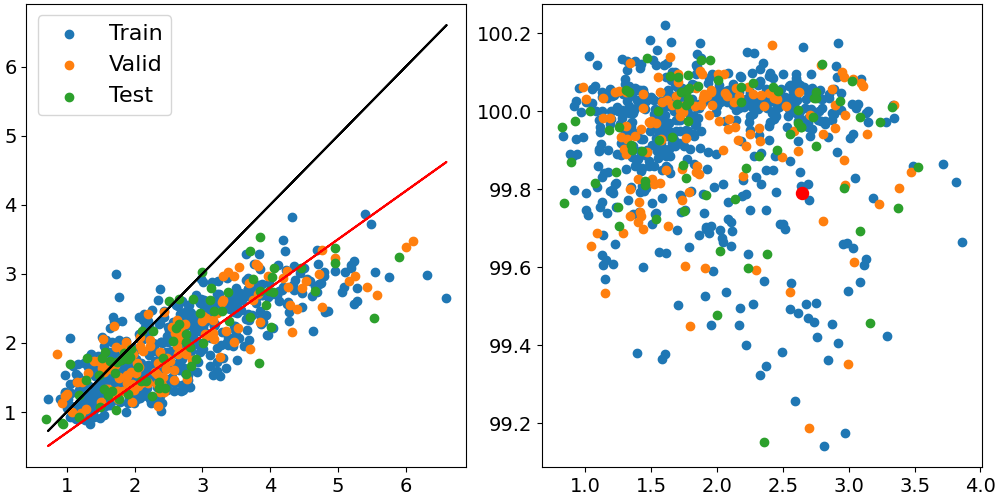

In [12]:
print(train_nesep_means_lorenzo[1][np.argmax(train_nesep_means_lorenzo[1])])

fig, axs = plt.subplots(1,2, figsize=(10, 5), constrained_layout=True)


axs[0].scatter(train_nesep_means_lorenzo[1], 1e-19*train_nesep_means_lorenzo[0], label='Train')
axs[0].scatter(val_nesep_means_lorenzo[1], 1e-19*val_nesep_means_lorenzo[0], label='Valid')
axs[0].scatter(test_nesep_means_lorenzo[1], 1e-19*test_nesep_means_lorenzo[0], label='Test')
axs[0].plot(train_nesep_means_lorenzo[1], train_nesep_means_lorenzo[1], color='black')
axs[0].plot(train_nesep_means_lorenzo[1], 0.7*train_nesep_means_lorenzo[1], color='red')
axs[0].legend()

axs[1].scatter(1e-19*train_nesep_means_lorenzo[0], train_tesep_means_lorenzo, label='Train')
axs[1].scatter(1e-19*val_nesep_means_lorenzo[0], val_tesep_means_lorenzo, label='Valid')
axs[1].scatter(1e-19*test_nesep_means_lorenzo[0], test_tesep_means_lorenzo, label='Test')
axs[1].scatter(1e-19*train_nesep_means_lorenzo[0][np.argmax(train_nesep_means_lorenzo[1])], train_tesep_means_lorenzo[np.argmax(train_nesep_means_lorenzo[1])], s=75, color='red')


plt.show()

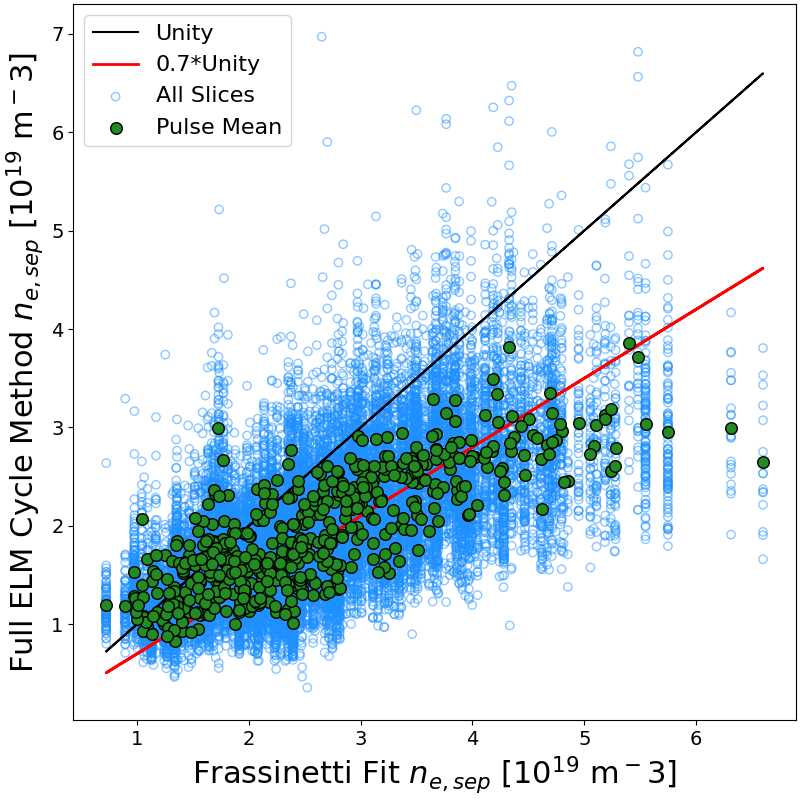

In [77]:
plt.close('all')
fig, axs = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=True)
for n, pulse in enumerate(train_by_pulse): 
    if n == 0: 
        label = 'All Slices'
    else: 
        label = None
    axs.scatter([train_means_lorenzo[1, n]]*len(pulse), 1e-19*pulse, facecolors='none', edgecolor='dodgerblue', alpha=0.5, zorder=0, label=label)
    # axs.scatter(train_means_lorenzo[1, n], np.quantile(1e-19*pulse, 0.85), color='gold',zorder=5)
    
axs.scatter(train_means_lorenzo[1], 1e-19*train_means_lorenzo[0], color='forestgreen', zorder=10, edgecolor=(0, 0, 0), label='Pulse Mean', s=70)
axs.plot(train_means_lorenzo[1], train_means_lorenzo[1], color='black', label='Unity')
axs.plot(train_means_lorenzo[1], 0.7*train_means_lorenzo[1], color='red', label='0.7*Unity', lw=2)
axs.legend()
axs.set_ylabel('Full ELM Cycle Method $n_{e, sep}$ [$10^{19}$ m$^-3$]',)
axs.set_xlabel('Frassinetti Fit $n_{e, sep}$ [$10^{19}$ m$^-3$]',)
plt.show()

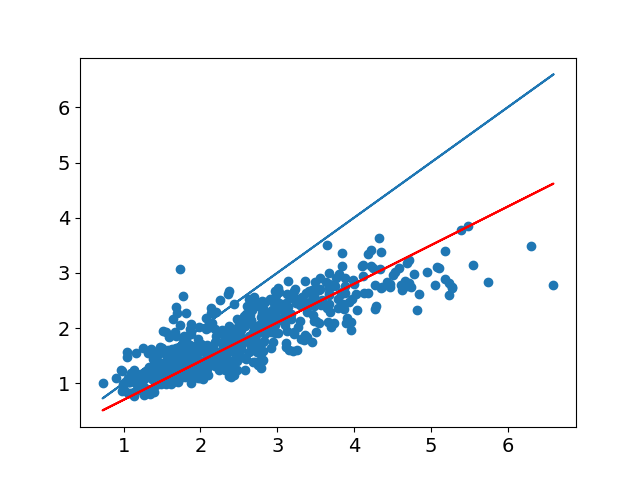

In [54]:
fig = plt.figure()

plt.scatter(train_means_lorenzo[1], 1e-19*train_means_lorenzo[0])
plt.plot(train_means_lorenzo[1], train_means_lorenzo[1])
plt.plot(train_means_lorenzo[1], 0.7*train_means_lorenzo[1], color='red')
plt.show()

In [7]:
model_hyperparams_physics = {'in_ch': 2, 'out_length':19,
                    'mach_latent_dim': 9, 'stoch_latent_dim': 3,
                    'beta_stoch': 1.0, 'beta_mach_unsup':  0.001,'beta_mach_sup':  0.0,
                    'alpha_mach': 1.0, 'alpha_prof': 20.0,  # 212, 306, 26, 295, 263, 336] 	[485, 499, 352, 432]
                    'start_sup_time': 1000,
                    'physics': False, 'gamma_stored_energy': 1.0, 'gamma_bpol': 1.0, 'gamma_beta': 1.0, 
                    'mp_hdims_aux': [64, 32], 'mp_hdims_cond':[64, 32], # 'mp_hdims_aux': [263, 469, 284], 'mp_hdims_cond':[20, 136, 54, 205, 154, 408], # 'mp_hdims_cond': [397, 369, 29, 113, 284], 'mp_hdims_aux': [122, 398, 463, 354, 399], 
                    'hidden_dims': [2, 4], 'loss_type': 'semi-supervised',}
model_physics = DIVAMODEL(**model_hyperparams_physics)
# model_name_physics = 'modelstatedict_SECULAR_semi-supervised-cutoffLOSS_9MD_3SD_0BMUN_15.0BMSUP_5.0BS_500AM_379AP_50EP' # Helsinki desktop example
model_name_physics = 'modelstatedict_SCHEDULER_PHYSICS_9MD_3SD_0BMUN_10.0BMSUP_1.5BS_500AM_960AP_50EP_100.0GAMMA' # Home Laptop Example
state_dict = torch.load('../Find_optimal_model/model_results/{}.pth'.format(model_name_physics))
model_physics.load_state_dict(state_dict['model'])

# Convert things to tensors 
norms_MP, norms_D, norms_T = state_dict['MP_norms'], state_dict['D_norms'], state_dict['T_norms']
MP_norm, MP_var = norms_MP
D_norm, D_var = norms_D
T_norm, T_var = norms_T


all_masks = np.vstack((train_mask, val_mask, test_mask)) > 0
all_psis = np.vstack((train_radii, val_radii, test_radii))
all_rmids = np.vstack((train_real_space_radii, val_real_space_radii, test_real_space_radii))

# Training Tensors 

train_mp_tensors = torch.tensor(train_y).float()
val_mp_tensors = torch.tensor(val_y).float()
test_mp_tensors = torch.tensor(test_y).float()
all_mp_tensors = torch.vstack((train_mp_tensors, val_mp_tensors, test_mp_tensors))


train_mp_normalized = standardize(train_mp_tensors, MP_norm, MP_var)
val_mp_normalized = standardize(val_mp_tensors, MP_norm, MP_var)
test_mp_normalized = standardize(test_mp_tensors, MP_norm, MP_var)

train_profiles = torch.tensor(train_X).float()
val_profiles = torch.tensor(val_X).float()
test_profiles = torch.tensor(test_X).float()
all_profiles = torch.vstack((train_profiles, val_profiles, test_profiles))

train_profiles_normalized = torch.clone(train_profiles).float()
train_profiles_normalized = normalize_profiles(train_profiles_normalized, T_norm, T_var, D_norm, D_var)

val_profiles_normalized = torch.clone(val_profiles).float()
val_profiles_normalized = normalize_profiles(val_profiles_normalized, T_norm, T_var, D_norm, D_var)

test_profiles_normalized = torch.clone(test_profiles).float()
test_profiles_normalized = normalize_profiles(test_profiles_normalized, T_norm, T_var, D_norm, D_var)


In [113]:
def calculate_neseps_in_set_with_predictions(set_ids, set_profiles, set_uncerts, set_masks, set_shot_numbers_by_slice, set_mps, pedestal_database): 
    iterator = tqdm(range(len(set_ids)))
    
    neseps_means_real_pred_lorenzo = np.zeros((3, len(set_ids)))
    nesep_real_means_by_pulse, nesep_pred_means_by_pulse = [], []
    for k in iterator: 
        slice_loc_in_set = set_ids[k]
        pulse_number = np.array(set_shot_numbers_by_slice)[set_ids[k]][0]
        
        
        JPDB_pulse = pedestal_database[pedestal_database['shot'] == pulse_number]
        lorenzo_nesep  = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[0]
     
        lorenzo_nesep_exp, lorenzo_nesep_fit = lorenzo_nesep
    
        sample_profiles, sample_uncerts, sample_masks, sample_mps = set_profiles[slice_loc_in_set], set_uncerts[slice_loc_in_set], set_masks[slice_loc_in_set], set_mps[slice_loc_in_set]
        
            
        pulse_real_neseps = calculate_nesep_for_pulse(sample_profiles, sample_uncerts, sample_masks, lbound_n = 0, ubound_n = 0.5e21, lbound_t=0, ubound_t=2000)
        
        # Get conditional preds
        conditional_profiles = conditional_inference_simple_mean((sample_profiles, _, sample_masks, _, sample_mps, _, _), model_physics)
        pulse_preds_neseps = calculate_nesep_for_pulse(conditional_profiles, sample_uncerts, sample_masks, lbound_n = 0, ubound_n = 0.5e21, lbound_t=0, ubound_t=2000, conditional_prediction=True)
        
        
        mean_real_pulse_nesep = pulse_real_neseps.mean()
        mean_pred_pulse_nesep = pulse_preds_neseps.mean()
        
        neseps_means_real_pred_lorenzo[:, k] = [mean_real_pulse_nesep, mean_pred_pulse_nesep, lorenzo_nesep_exp]
        
        nesep_real_means_by_pulse.append(pulse_real_neseps)
        nesep_pred_means_by_pulse.append(pulse_preds_neseps)
        
        iterator.set_description_str(str(pulse_number))
        iterator.set_postfix_str('fras{:.3}mean{:.4}pred{:.4}'.format(lorenzo_nesep_exp, 1e-19*mean_real_pulse_nesep, 1e-19*mean_pred_pulse_nesep ))
        
        
        
    return neseps_means_real_pred_lorenzo, nesep_real_means_by_pulse, nesep_pred_means_by_pulse


In [ ]:
neseps_conditional_real_lorenzo, neseps_real_by_pulse, neseps_conditional_by_pulse = calculate_neseps_in_set_with_predictions(train_pulse_idxs, train_profiles, train_uncert, train_mask, train_pulse_order, train_mp_tensors, JET_PDB)
# train_means_lorenzo, train_by_pulse = calculate_neseps_in_set(train_pulse_idxs, train_X, train_uncert, train_mask, train_pulse_order, JET_PDB)

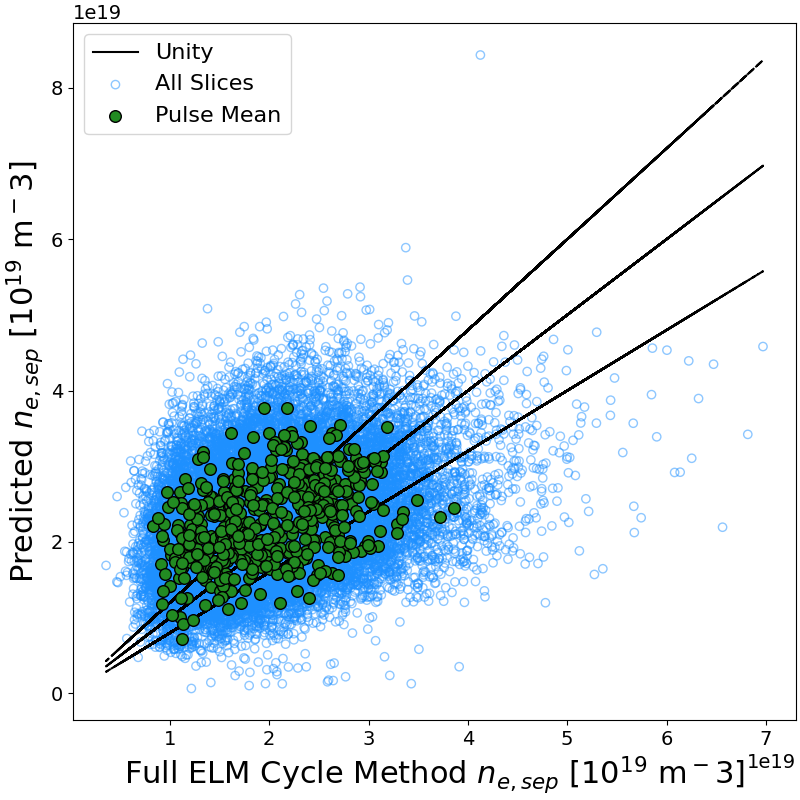

In [103]:
plt.close('all')
fig, axs = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=True)
for n, (pulse_real, pulse_cond) in enumerate(zip(neseps_real_by_pulse, neseps_conditional_by_pulse)): 
    if n == 0: 
        label = 'All Slices'
    else: 
        label = None
    axs.scatter(pulse_real, pulse_cond, facecolors='none', edgecolor='dodgerblue', alpha=0.5, zorder=0, label=label)
    axs.plot(pulse_real, pulse_real, color='black')
    axs.plot(pulse_real, 1.2*pulse_real, color='black',ls='--')
    axs.plot(pulse_real, 0.8*pulse_real, color='black',ls='--')
    
axs.scatter(neseps_conditional_real_lorenzo[0], neseps_conditional_real_lorenzo[1], color='forestgreen', zorder=10, edgecolor=(0, 0, 0), label='Pulse Mean', s=70)
axs.plot(neseps_conditional_real_lorenzo[0], neseps_conditional_real_lorenzo[0], color='black', label='Unity')
axs.legend()
axs.set_xlabel('Full ELM Cycle Method $n_{e, sep}$ [$10^{19}$ m$^-3$]',)
axs.set_ylabel('Predicted $n_{e, sep}$ [$10^{19}$ m$^-3$]',)
plt.show()

In [5]:
line_of_sight = pd.read_csv('/home/adam/Desktop/pulse_91962_line_of_sight.dat', skiprows=4, names=['R', 'NE'], sep='  ')['R'].to_list()

/home/adam/ENR_Sven/singularity/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [58]:

def mtanh(r_vals, h1, h0, p, w, s):
    x = (p-r_vals) / (w/2.0)
    return (h1/2.0 - h0/2.0)*((((1+s*x)*np.exp(x)) - np.exp(-x)) / (np.exp(x) + np.exp(-x)) + 1) + h0
    

def plot_profiles_and_mtanh(profiles, rmids, masks, uncerts, lorenzo_fit_ne, lorenzo_fit_te, lorenzo_nesep, pulse_neseps, pulse_teseps):
    d_profs, t_profs = profiles[:, 0, :], profiles[:, 1, :]
    dne_profs, dte_profs = uncerts[:, 0, :], uncerts[:, 1, :]
    
    
    # fig = plt.figure(figsize=(8, 10))
    # gs = fig.add_gridspec(2, hspace=0)
    # axs = gs.subplots(sharex=True)
    
    fig = plt.figure(constrained_layout=True, figsize=(20, 12))
    # gs = GridSpec(2, 2, figure=fig)

    
    gs1 = GridSpec(2, 1, left=0.05, right=0.48, wspace=0.05)
    ax2 = fig.add_subplot(gs1[0])
    ax1 = fig.add_subplot(gs1[1])
    
    ax1.set_xlabel('$T_e$ [eV]')
    ax2.set_xlabel('$n_e$ [m$^{-3}$]')
    ax2.set_ylabel('PDF')
    ax1.set_ylabel('PDF')
    
    gs2 = GridSpec(2, 1, left=0.55, right=0.98, hspace=0.0)
    ax3 = fig.add_subplot(gs2[0])
    ax4 = fig.add_subplot(gs2[1])
    
    ax4.set_ylabel('$T_e$ [eV]')
    ax4.set_xlabel('HRTS Line of Sight [m]')
    ax3.set_ylabel('$n_e$ [m$^{-3}$]')

    los_radii = np.array(line_of_sight[-19:])
    
    mtanh_radius = np.linspace(3.78, 3.9, 300)
    
    offset = 0.033
    
    tesep_loc = np.argmin(np.abs(mtanh(mtanh_radius, *lorenzo_fit_te) - 0.1))
    
    
    myclip_a, myclip_b = 0, 1000
    myclip_an, myclip_bn = 0, 1.5e21
    
    for sl, (d_pr, t_pr, dne_pr, dte_pr, radius, mask) in enumerate(zip(d_profs, t_profs, dne_profs, dte_profs, rmids, masks)):
        bool_mask = mask > 0
        d_prm, t_prm, dne_prm, dte_prm = d_pr[bool_mask], t_pr[bool_mask], dne_pr[bool_mask], dte_pr[bool_mask]
        for mea, (mu_t, var_t, mu_n, var_n) in enumerate(zip(t_prm, dte_prm, d_prm, dne_prm)): 
            
            if mea == 0 and sl == 0: 
                label_t_sep  = '90 < $T_e$ < 110' 
            else: 
                label_t_sep = None
            a, b = (myclip_a - mu_t) / var_t, (myclip_b - mu_t) / var_t
            r = truncnorm.rvs(a, b, mu_t, var_t, size=10000)
            x_t = np.linspace(truncnorm.ppf(0.0001, a, b, mu_t, var_t), truncnorm.ppf(0.9999, a, b, mu_t, var_t), 10000)
            x_tesep = x_t[np.logical_and(x_t>90, x_t<110)]
            ax1.plot(x_t, truncnorm.pdf(x_t, a, b, mu_t, var_t),
               'b-', lw=1, alpha=0.6, zorder=10)
            ax1.plot(x_tesep, truncnorm.pdf(x_tesep, a, b, mu_t, var_t),
                'g-', lw=3, alpha=0.6, label=label_t_sep, zorder=20)
            # ax1.hist(r, density=True, histtype='stepfilled', alpha=0.2)
            
            a, b = (myclip_an - mu_n) / var_n, (myclip_bn - mu_n) / var_n
    
            r = truncnorm.rvs(a, b, mu_n, var_n, size=10000)
            x = np.linspace(truncnorm.ppf(0.1, a, b, mu_n, var_n),

                            truncnorm.ppf(0.9, a, b, mu_n, var_n), 10000)

            x_nesep = x[np.logical_and(x_t>90, x_t<110)]

            ax2.plot(x, truncnorm.pdf(x, a, b, mu_n, var_n),
                   'b-', lw=1, alpha=0.6, zorder=10)
            ax2.plot(x_nesep, truncnorm.pdf(x_nesep, a, b, mu_n, var_n),
                   'g-', lw=3, alpha=0.99, zorder=20, label= label_t_sep)
            
        
        ax3.scatter(radius[bool_mask], d_pr[bool_mask], color='dodgerblue', edgecolor=(0, 0, 0), zorder=20, s=75)
        ax4.scatter(radius[bool_mask], t_pr[bool_mask], color='tan', edgecolor=(0, 0, 0), zorder=0, s=75)
        
    ax3.plot(mtanh_radius - offset, 1e19*mtanh(mtanh_radius, *lorenzo_fit_ne), color='blue', lw=4, zorder=30, label='Frassinetti Fit')
    ax4.plot(mtanh_radius -offset, 1e3*mtanh(mtanh_radius, *lorenzo_fit_te), color='orange', lw=4, label='Frassinetti Fit')
    
    ax4.vlines(mtanh_radius[tesep_loc]  - offset, 0, 1000, color='black', lw=3, label='$R(T_e = 100$ [eV])')
    ax3.vlines(mtanh_radius[tesep_loc] - offset, -1e19, 1e20, color='black', lw=3, label='$R(T_e = 100$ [eV])')
    
    ax4.set_ylim(-50, 950)
    ax3.set_ylim(-0.5e19, 1.15e20)
    ax2.set_ylim(1e-20, 1.8e-19)
    
    ax4.hlines(pulse_teseps, 3.79, 3.82, color='red', ls='--')
    ax4.hlines(100, 3.79, 3.82, color='black', ls='--', label='$T_e = 100$ [eV]')
    
    
    ax3.hlines(lorenzo_nesep*1e19, 3.79, 3.82, lw=3, color='magenta', ls='--', label='$n_{e, sep}$ Frassinetti', zorder=15)
    ax3.hlines(pulse_neseps, 3.79, 3.83, color='red', lw=3, ls='--', label='$n_{e, sep}$ Kit', zorder=15)
    
    
    ax2.vlines(pulse_neseps, 2e-20, 1.0e-19, color='red', ls='--', label='$n_{e, sep}$ Kit', zorder=15, lw=3)
    ax2.vlines(lorenzo_nesep*1e19, 2e-20, 1.0e-19, color='magenta', ls='--', label='$n_{e, sep}$ Frassinetti', zorder=15, lw=3)
    axs= [ax1, ax2, ax3, ax4]
    for ax in axs: 
        ax.legend()
    fig.suptitle('Pulse 91962, 52.48s -> 53.43s')
    ax2.set_title('$n_{e,sep}$ approximation via normal distributions')
    ax3.set_title('Profile and Fit comparisons')
    plt.savefig('./pulse_91962_nesep_comparison.svg')
    plt.savefig('./pulse_91962_nesep_comparison.png')
    plt.show()
    pass 
def look_at_high_nesep(set_ids, set_profiles, set_uncerts, set_masks, set_shot_numbers_by_slice, set_mps, set_rmids, train_time_pulse_ids, pedestal_database): 
    iterator = tqdm(range(len(set_ids)))
    
    neseps_means_real_pred_lorenzo = np.zeros((3, len(set_ids)))
    nesep_real_means_by_pulse, nesep_pred_means_by_pulse = [], []
    for k in iterator: 
        slice_loc_in_set = set_ids[k]
        pulse_number = np.array(set_shot_numbers_by_slice)[set_ids[k]][0]
        
        if pulse_number != 91962: 
            continue
        
        print(np.array(train_time_pulse_ids)[slice_loc_in_set])
        
        JPDB_pulse = pedestal_database[pedestal_database['shot'] == pulse_number]
        lorenzo_nesep  = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[0]
        lorenzo_fit_ne = np.array([JPDB_pulse['nepedheight10^19(m^-3)'].values[0], 0.5,  JPDB_pulse['nepositionRmid(m)'].values[0],0.01*JPDB_pulse['NepedestalwidthRmid(cm)'].values[0],JPDB_pulse['neinnerslope'].values[0], ])
        lorenzo_fit_te = np.array([JPDB_pulse['Tepedheight(keV)'].values[0], 0.0,  JPDB_pulse['TepositionRmid(m)'].values[0],0.01*JPDB_pulse['TepedestalwidthRmid(cm)'].values[0],JPDB_pulse['Teinnerslope'].values[0], ])
        
        lorenzo_nesep_exp, lorenzo_nesep_fit = lorenzo_nesep
    
        sample_profiles, sample_uncerts, sample_masks, sample_mps, sample_rmids = set_profiles[slice_loc_in_set], set_uncerts[slice_loc_in_set], set_masks[slice_loc_in_set], set_mps[slice_loc_in_set], set_rmids[slice_loc_in_set]
            
        pulse_neseps, pulse_teseps = calculate_nesep_for_pulse(sample_profiles, sample_uncerts, sample_masks, lbound_n = 0, ubound_n = 0.5e21, lbound_t=0, ubound_t=2000)
        print(pulse_neseps)
        max_val = max(pulse_neseps)
        lor_stand = lorenzo_nesep_fit*1e19
        diff = (lorenzo_nesep_fit*1e19) - max(pulse_neseps)
        print(max(pulse_neseps))
        print(lorenzo_nesep_fit*1e19)
        # print(((lorenzo_nesep_fit*1e19) - max(pulse_neseps)) / lorenzo_nesep_fit*1e19)
        print(diff/lor_stand*100)
        # plot_profiles_and_mtanh(sample_profiles, sample_rmids, sample_masks, sample_uncerts, lorenzo_fit_ne, lorenzo_fit_te, lorenzo_nesep_fit, pulse_neseps, pulse_teseps)
                
        iterator.set_description_str(str(pulse_number))
        
        
        
    return None
plt.close('all')
look_at_high_nesep(train_pulse_idxs, train_profiles, train_uncert, train_mask, train_pulse_order, train_mp_tensors, train_real_space_radii, train_ids, JET_PDB)

  0%|          | 0/533 [00:00<?, ?it/s]

['91962/52.48' '91962/52.53' '91962/52.58' '91962/52.63' '91962/52.68'
 '91962/52.73' '91962/52.78' '91962/52.83' '91962/52.88' '91962/52.93'
 '91962/52.98' '91962/53.03' '91962/53.08' '91962/53.13' '91962/53.18'
 '91962/53.23' '91962/53.28' '91962/53.33' '91962/53.38' '91962/53.43']
[2.89339342e+19 3.19565887e+19 3.75938945e+19 2.65557737e+19
 2.59180198e+19 2.35529191e+19 3.47892837e+19 3.76948380e+19
 1.91092159e+19 2.90442845e+19 2.52842904e+19 2.32760154e+19
 4.16874274e+19 3.55587545e+19 3.47982168e+19 2.42152839e+19
 3.13155560e+19 2.62405613e+19 3.12336679e+19 2.91429193e+19]
4.168742741632022e+19
6.6093907356e+19
36.92697393153011


In [63]:
def conditional_inference_simple_mean(PULSE, model=None, norms=(None, None, None, None)):
    D_norm, D_var, T_norm,T_var = norms
    X, PSI, MASK, ID, MPS, _, UNCERT = PULSE
    X[:, 0] = standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = standardize(X[:, 1], T_norm, T_var)
    MPS = standardize(MPS, MP_norm, MP_var)
    with torch.no_grad():         
        cond_mu, cond_var =  model.p_zmachx(MPS)
        z_mach = model.reparameterize(cond_mu, cond_var)
        mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(X)
        z_stoch = mu_stoch
        z_mach = cond_mu
        z_conditional = torch.cat((z_stoch, z_mach), 1)
        out_profs_cond = model.p_yhatz(z_conditional)
    out_profs_cond[:, 0] = de_standardize(out_profs_cond[:, 0], D_norm, D_var)
    out_profs_cond[:, 1] = de_standardize(out_profs_cond[:, 1], T_norm, T_var)
    MPS = de_standardize(MPS, MP_norm, MP_var)
    X[:, 0] = de_standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = de_standardize(X[:, 1], T_norm, T_var)
    return out_profs_cond
from matplotlib.gridspec import GridSpec


In [9]:
from matplotlib.gridspec import GridSpec


In [43]:
plt.close('all')